# plotting SHARP keywords and images with python + d3

In this notebook, we will be plotting keywords and images, from data taken by the Helioseismic and Magnetic Imager (HMI) instrument on NASA's Solar Dynamics Observatory (SDO) satellite, using <a  href="https://mpld3.github.io/">mpld3</a>, a python interface for <a  href="http://d3js.org/">d3</a>. SDO takes about a terabyte and a half of data a day, which is more data than any other satellite in NASA history. 

Data from the HMI and Atmospheric Imaging Assembly (AIA) instruments aboard SDO are stored at Stanford University. The metadata are stored in a pSQL database called the Data Record Management System, or DRMS. The image data are stored separately, in storage units called the Storage Unit Management System, or SUMS. Data are merged together, upon export from both systems, as FITS files. DRMS and SUMS together constitute the Joint Science Operations Center, or JSOC.

The easiest way to access SDO HMI and AIA data is via the python `drms` module, available at [PyPI](https://pypi.python.org/pypi/drms). In addition to the numerous tutorials on both the [Read the Docs](https://drms.readthedocs.io/en/stable/tutorial.html) and [Github](https://github.com/kbg/drms/tree/master/examples), all the examples below utilize the `drms` module. First we'll import the module, and some others:

In [1]:
import drms
import json, numpy as np, matplotlib.pylab as plt, matplotlib.ticker as mtick
from datetime import datetime as dt_obj
import urllib
from astropy.io import fits
from sunpy.cm import color_tables as ct
from matplotlib.dates import *
import mpld3
import matplotlib.image as mpimg
%matplotlib inline
%config InlineBackend.figure_format='retina'

The first step in querying for SDO HMI and AIA data is to establish a connection to JSOC. This can be done with the `Client()` class.

In [2]:
import drms
c = drms.Client()

The `Client()` class allows one to access both metadata and image data simultaneously via a data series. A data series contains all of particular type of data — e.g. there is a series for continuum intensity data, another for magnetic field data, and so forth. Read Section 4 of the [SDO Analysis Guide](https://www.lmsal.com/sdodocs/doc/dcur/SDOD0060.zip/zip/entry/) for more information about how to build a data series query. For example, to find all the SHARP data series, execute the following regular expression query:

In [3]:
c.series(r'hmi\.sharp_')

[u'hmi.sharp_720s',
 u'hmi.sharp_720s_nrt',
 u'hmi.sharp_cea_720s',
 u'hmi.sharp_cea_720s_nrt']

## plotting the metadata

The query below retrieves both metadata and image data for active region 11158, which produced an X2.2-class flare on February 15, 2011 at 1:56 UT, from the SHARP data series. The [SHARP data series](https://link.springer.com/article/10.1007%2Fs11207-014-0529-3) include patches of vector magnetic field data taken by the HMI instrument. These patches encapsulate automatically-detected active regions that are tracked throughout the entirety of their disk passage. The `c.query()` method takes three arguments:
* The first argument is the data series, called `hmi.sharp_cea_720s`, appended with two prime keys: the HARP number (377) and the time range (2011.02.14_15:00:00/12h). A prime key, or set of prime keys, is a unique identifier.
* The second argument in the search query is a list of keywords. The following commands will display a list of keywords that belong to the series `hmi.sharp_cea_720s`: <br/>
        si = c.info('hmi.sharp_cea_720s') 
        si.keywords 
* The third argument in the search query is a list of segments. The following commands will display a list of segments that belong to the series `hmi.sharp_cea_720s`: <br/>
        si = c.info('hmi.sharp_cea_720s') 
        si.segments 

In [4]:
keys, segments = c.query('hmi.sharp_cea_720s[377][2011.02.14_15:00:00/12h]', key='T_REC, USFLUX, ERRVF', seg='Br')

To convert the keyword `T_REC` into a datetime object, we can use the function below.

In [5]:
def parse_tai_string(tstr,datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    if datetime: return dt_obj(year,month,day,hour,minute)
    else: return year,month,day,hour,minute

In [6]:
t_rec = np.array([parse_tai_string(keys.T_REC[i],datetime=True) for i in range(keys.T_REC.size)])

Now for some plotting! matplotlib.pyplot generates two objects: a figure and axes. The data are ascribed to the axes. The time axes in particular requires some formatting; in order to free it of clutter, we'll plot tick marks every three hours and label them accordingly.

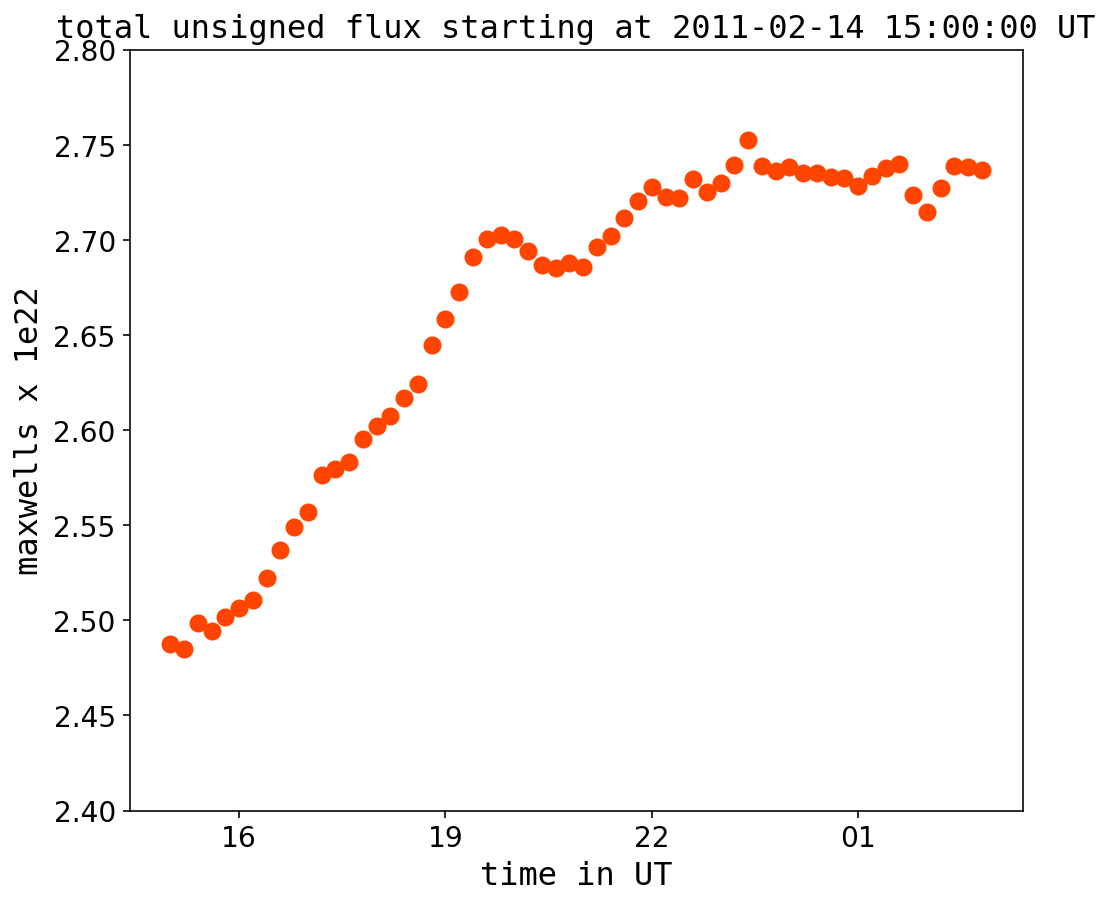

In [7]:
fig, ax = plt.subplots(figsize=(8,7))      # define the size of the figure
orangered = (1.0,0.27,0,1.0)                # create an orange-red color

# define some style elements
marker_style = dict(linestyle='', markersize=8, fillstyle='full',color=orangered,markeredgecolor=orangered)
text_style = dict(fontsize=16, fontdict={'family': 'monospace'})
ax.tick_params(labelsize=14)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

# ascribe the data to the axes
ax.plot(t_rec, (keys.USFLUX)/(1e22),'o',**marker_style)
ax.errorbar(t_rec, (keys.USFLUX)/(1e22), yerr=(keys.ERRVF)/(1e22), linestyle='',color=orangered)

# format the x-axis with universal time
locator = AutoDateLocator()
locator.intervald[HOURLY] = [3] # only show every 3 hours
formatter = DateFormatter('%H')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# set yrange 
ax.set_ylim([2.4,2.8])

# label the axes and the plot
ax.set_xlabel('time in UT',**text_style)
ax.set_ylabel('maxwells x 1e22',**text_style)
ax.set_title('total unsigned flux starting at '+str(t_rec[0])+' UT',**text_style) # annotate the plot with a start time
mpld3.disable_notebook()

Yaay! But we can do better by generating an interactive plot that runs on d3. The d3 plot generates three buttons in the lower left-hand corner: home, pan, and zoom. This allows us to explore the plot in detail (for example, zoom in significantly to see the error bars).

We can also generate the html to put this visualization on any website using the following command:  
<code>print(mpld3.fig_to_html(fig, template_type="simple"))</code>.

In [8]:
mpld3.enable_notebook()
mpld3.display(fig)

## plotting the image data

Since we also queried for the image data — specifically, for the radial component of the magnetic field — we can view these data by downloading the unmerged FITS file, which means that the header metadata has not been merged with the image data, via `astropy`. This is the quickest and easiest option as the `drms.Client()` class can query the header and image data independently, there is no need to store FITS files locally, and there is no need to wait for the exportdata system to generate FITS files.

In [9]:
url = 'http://jsoc.stanford.edu' + segments.Br[54]  # add the jsoc.stanford.edu suffix to the segment name
photosphere_image = fits.open(url)                  # download the data

This image is at 2011-02-15 01:48:00.
The dimensions of this image are 377 by 744 .


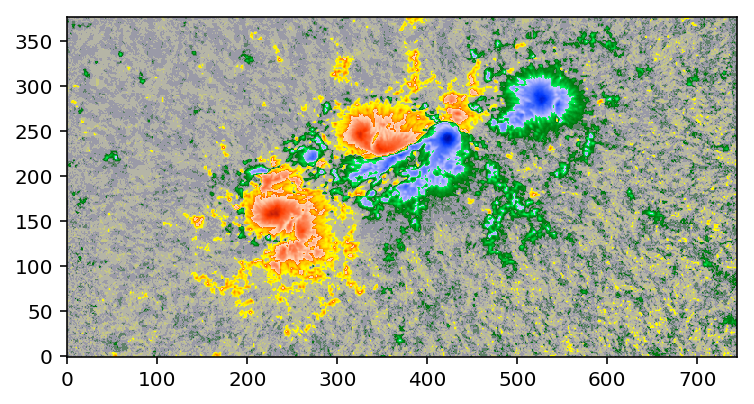

In [10]:
mpld3.disable_notebook()
hmimag = plt.get_cmap('hmimag')
plt.imshow(photosphere_image[1].data,cmap=hmimag,origin='lower',vmin=-3000,vmax=3000)
print 'This image is at '+str(t_rec[54])+'.'
print 'The dimensions of this image are',photosphere_image[1].data.shape[0],'by',photosphere_image[1].data.shape[1],'.'

## exporting data

The JSOC allows users to export data as FITS files, jpg images and movies in mp4 or mpg format. 

<b> n.b. The code below will only work with a valid e-mail address. </b> In order to obtain one, users must register on the [JSOC exportdata website](http://jsoc.stanford.edu/ajax/exportdata.html). It is worthwhile to have a read around that webpage before using the `drms` module to export data.

In [11]:
email = 'your@email.address'

In [12]:
c = drms.Client(email=email, verbose=True)

### exporting a jpg image

We can easily export any image data as a jpg using one of several color tables (see the [expordata website](http://jsoc.stanford.edu/ajax/exportdata.html) under the jpg protocol for a list of color tables). Here is an example with NOAA Active Region 11158 at the time of the X2.2-class flare.

In [13]:
protocol_args = {'ct': 'HMI_mag.lut', 'min': -3000, 'max': 3000}

In [14]:
r = c.export('hmi.sharp_cea_720s[377][2011.02.14_02:00:00]{Br}', protocol='jpg', protocol_args=protocol_args, email=email)

In [15]:
print r.request_url

Export request pending. [id="JSOC_20170324_567_X_IN", status=2]
Waiting for 4 seconds...
http://jsoc.stanford.edu/SUM98/D914266647/S00000


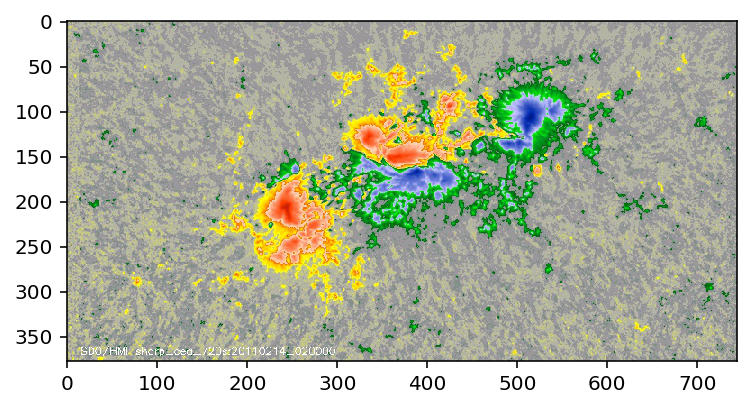

In [16]:
url = r.urls['url'][0]
data = urllib.urlretrieve(url)
image = mpimg.imread(data[0])
plt.imshow(image)

### exporting a movie

We can also easily create a movie using any image data! The movie below tracks NOAA Active Region 11158 over the same time interval as the plot above. In this case, the segment information, Br, is notated in the curly brackets within the data series query. 

In [17]:
r = c.export('hmi.sharp_cea_720s[377][2011.02.14_15:00:00/12h]{Br}', protocol='mpg', protocol_args=protocol_args, email=email)

In [18]:
print r.request_url

Export request pending. [id="JSOC_20170324_568_X_IN", status=2]
Waiting for 0 seconds...
http://jsoc.stanford.edu/SUM97/D914266843/S00000


In [19]:
print "You can download the movie from here:", r.urls['url'][0]

You can download the movie from here: http://jsoc.stanford.edu/SUM97/D914266843/S00000/hmi.sharp_cea_720s.mpg
